# Author

Daniel Soto

# Introduction

This notebook provides supplementary materials for the work related to marginal cost modeling and observations in a set of diesel microgrids.


This notebook uses a mean of the individual regression results from generators to form a composite generator model of the form

$$ \textrm{Fuel Rate} = \textrm{No-Load Consumption} + \beta \cdot P_L $$

Where $\beta$ is the marginal fuel rate per unit of delivered load and $P_L$ is the power delivered by the generator.

This model is applied to the observed power data to predict the fuel use at the loads in the villages.


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import WP19_analysis as wpa
import statsmodels.api as sm
import tabulate

/Users/dsoto/miniconda3/envs/wp19/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Generator Model

In [10]:
# load data and add a column for the delivered load in kVA rather than a percentage

gen_data = pd.read_csv('../data_sheets/generator_data.csv', comment='#')
gen_data['load_kVA'] = gen_data['rated_power_kVA'] * gen_data['percent_load'] / 100
gen_data.head()

# iterate over each model and perform a fit and show table of results

generator_fits = []
models = gen_data['model_number'].unique()
for m in models:
    model_data = gen_data[gen_data['model_number'] == m]
    y = model_data['fuel_consumption_lph']
    X = model_data['load_kVA']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    generator_fits.append({'model': m,
                           'rated_power_kVA':model_data['rated_power_kVA'].mean(), 
                           'no_load_consumption': model.params['const'],
                           'fuel_coefficient': model.params['load_kVA'],
                           'R-squared': model.rsquared})
    
generator_fits = pd.DataFrame(generator_fits)
generator_fits

marginal_fuel_rate = generator_fits['fuel_coefficient'].mean()
no_load_fuel_rate = generator_fits['no_load_consumption'].mean()
print('marginal fuel rate (lph) =', marginal_fuel_rate)
print('no load fuel consumption (lph) =', no_load_fuel_rate)
print(generator_fits['fuel_coefficient'].std())
print(generator_fits['no_load_consumption'].std())
print(generator_fits['fuel_coefficient'].std()/generator_fits['fuel_coefficient'].mean())
print(generator_fits['no_load_consumption'].std()/generator_fits['no_load_consumption'].mean())

def get_fuel_rate(load_power=None):
    return load_power * marginal_fuel_rate + no_load_fuel_rate

def get_SFC(load_power=None, fuel_rate=None):
    return fuel_rate / load_power

marginal fuel rate (lph) = 0.256012109187
no load fuel consumption (lph) = 1.38541666667
0.0189809767414
0.642072382559
0.074140933418
0.463450742298


Specific Fuel Consumption Duration Curves


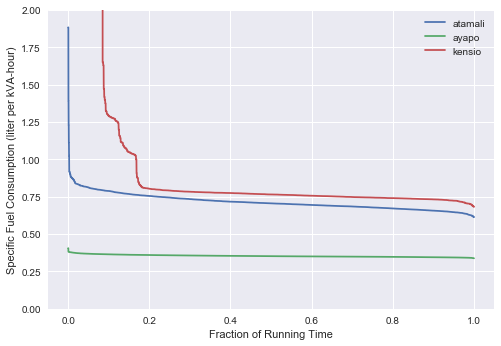

In [4]:
fig, ax = plt.subplots()
for rfd in wpa.raw_file_data[2:]:
    # load power data
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    kVA = energy_data['kVA sliding window Demand'].dropna().values
    kVA = kVA[kVA != 0.0]
    # create SFC timeseries from load data
    fuel_rate = get_fuel_rate(load_power=kVA)
    fuel_per_kVA_hour = get_SFC(load_power=kVA, fuel_rate=fuel_rate)
    # sort and reverse for duration curve
    fuel_per_kVA_hour.sort()
    fuel_per_kVA_hour = fuel_per_kVA_hour[::-1]
    index = np.linspace(0, 1, len(fuel_per_kVA_hour))
    plt.plot(index, fuel_per_kVA_hour,
             label=vname)

print('Specific Fuel Consumption Duration Curves')
plt.legend()
plt.xlabel('Fraction of Running Time')
plt.ylabel('Specific Fuel Consumption (liter per kVA-hour)')
plt.ylim((0,2))
plt.savefig('../plots/specific_fuel_consumption_duration.png')
plt.show()

In [5]:
tmp_data = []
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    kVA = energy_data['kVA sliding window Demand'].dropna().values
    kVA = kVA[kVA != 0.0]
    mean_kVA = kVA.mean()
    rated_load = rfd['genset_rating_kVA']
    #load = rating * 1.0
    #specific_fuel_consumption_100 = get_fuel_rate(rating, load) / load 
    SFC_100 = get_SFC(fuel_rate=get_fuel_rate(load_power=rated_load), load_power=rated_load)
    mean_load = mean_kVA
    #specific_fuel_consumption_mean = get_fuel_rate(rating, load) / load
    SFC_mean = get_SFC(fuel_rate=get_fuel_rate(load_power=mean_load), load_power=mean_load)
    tmp_data.append({'Village' : vname.title(),
                 'Genset rating (kVA)' : rfd['genset_rating_kVA'],
                 'expected fuel rate at 100% (lph)' : get_fuel_rate(load_power=rated_load),
                 'mean load (kVA)' : mean_load,
                'expected fuel rate at mean load (lph)' : get_fuel_rate(load_power=mean_load),
                'Expected specific fuel consumption at 100% load (lpkVA)': SFC_100,
                'Expected specific fuel consumption at mean load (lpkVA)': SFC_mean,
                })

data = pd.DataFrame(tmp_data)
#data = data.set_index(['village'])
#data = data[['genset rating kVA', 
#             'expected fuel rate at 100% (lph)', 
#             'mean load (kVA)',
#             'expected fuel rate at mean load (lph)']]
data = data[['Village', 
             'Genset rating (kVA)', 
             'mean load (kVA)',
             'expected fuel rate at 100% (lph)',
             'expected fuel rate at mean load (lph)',
             'Expected specific fuel consumption at 100% load (lpkVA)',
             'Expected specific fuel consumption at mean load (lpkVA)']]

data

,Village,Genset rating (kVA),mean load (kVA),expected fuel rate at 100% (lph),expected fuel rate at mean load (lph),Expected specific fuel consumption at 100% load (lpkVA),Expected specific fuel consumption at mean load (lpkVA)
0,Atamali,25.0,3.057530,7.785719,2.168181,0.311429,0.709128
1,Ayapo,40.0,14.323494,11.625901,5.052404,0.290648,0.352735
2,Kensio,35.0,2.451428,10.345840,2.013012,0.295595,0.821159


In [6]:
# prepare table for manuscript

data = data[['Village', 
             'Genset rating (kVA)', 
             'Expected specific fuel consumption at 100% load (lpkVA)',
             'Expected specific fuel consumption at mean load (lpkVA)']]

table_string = tabulate.tabulate(data, tablefmt='pipe', floatfmt='.3g', headers=data.columns, showindex=False)

print(table_string)

with open('../tables/modeled_SFC.md', 'w') as f:
    f.write(table_string)
    
data

| Village   |   Genset rating (kVA) |   Expected specific fuel consumption at 100% load (lpkVA) |   Expected specific fuel consumption at mean load (lpkVA) |
|:----------|----------------------:|----------------------------------------------------------:|----------------------------------------------------------:|
| Atamali   |                    25 |                                                     0.311 |                                                     0.709 |
| Ayapo     |                    40 |                                                     0.291 |                                                     0.353 |
| Kensio    |                    35 |                                                     0.296 |                                                     0.821 |


,Village,Genset rating (kVA),Expected specific fuel consumption at 100% load (lpkVA),Expected specific fuel consumption at mean load (lpkVA)
0,Atamali,25.0,0.311429,0.709128
1,Ayapo,40.0,0.290648,0.352735
2,Kensio,35.0,0.295595,0.821159


# TODO: organize materials below

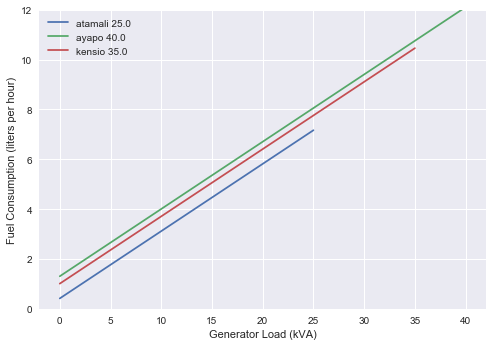

In [5]:
# plot fuel consumption for each village compared to load
fig, ax = plt.subplots()
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    load = np.linspace(0, 1, 2) * rfd['genset_rating_kVA']
    power = rfd['genset_rating_kVA']
    y = get_fuel_rate(power, load)
    plt.plot(load, y, label=vname + ' ' + str(rfd['genset_rating_kVA']))
    
plt.legend()
plt.ylim((0, 12))
plt.xlabel('Generator Load (kVA)')
plt.ylabel('Fuel Consumption (liters per hour)')
plt.show()

Generator Specific Fuel Consumption


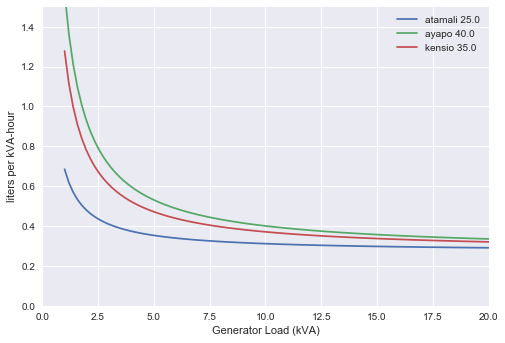

In [6]:
# plot specific fuel consumption for each generator

max_load = 20.0

fig, ax = plt.subplots()
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    load = np.linspace(0.05, 1.0, 100) * max_load
    hours = 1.0
    load_hours = load * hours
    fuel_rate = get_fuel_rate(rfd['genset_rating_kVA'], load)
    fuel = fuel_rate * hours
    heat_rate = fuel / load_hours
    plt.plot(load, heat_rate, label=vname + ' ' + str(rfd['genset_rating_kVA']))

print('Generator Specific Fuel Consumption')
plt.xlim((0, max_load))
plt.ylim((0, 1.5))
#plt.ylim((0, 0.4))
plt.legend()
plt.xlabel('Generator Load (kVA)')
plt.ylabel('liters per kVA-hour')
plt.show()

Load Duration Curves (kVA)


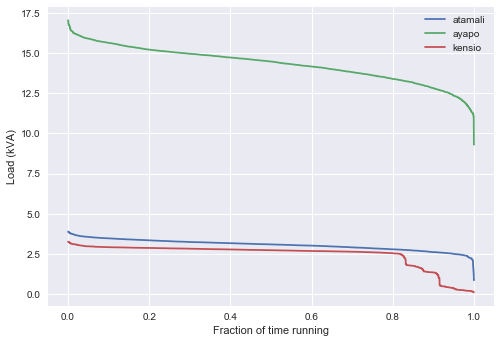

In [7]:
fig, ax = plt.subplots()
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    kVA = energy_data['kVA sliding window Demand'].dropna().values
    kVA = kVA[kVA != 0.0]
    kVA.sort()
    kVA = kVA[::-1]
    index = np.linspace(0, 1, len(kVA))
    plt.plot(index, kVA, label=vname)

print('Load Duration Curves (kVA)')
plt.legend()
plt.xlabel('Fraction of time running')
plt.ylabel('Load (kVA)')
plt.show()

Load Duration Curves (percent rated load)


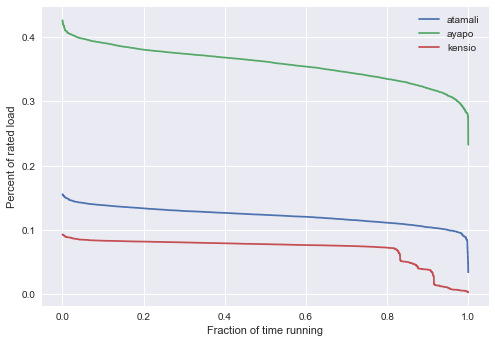

In [8]:
fig, ax = plt.subplots()
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    kVA = energy_data['kVA sliding window Demand'].dropna().values
    kVA = kVA / rfd['genset_rating_kVA']
    kVA = kVA[kVA != 0.0]
    kVA.sort()
    kVA = kVA[::-1]
    index = np.linspace(0, 1, len(kVA))
    plt.plot(index, kVA, label=vname)

print('Load Duration Curves (percent rated load)')
plt.legend()
plt.xlabel('Fraction of time running')
plt.ylabel('Percent of rated load')
plt.show()

Specific Fuel Consumption Duration Curves


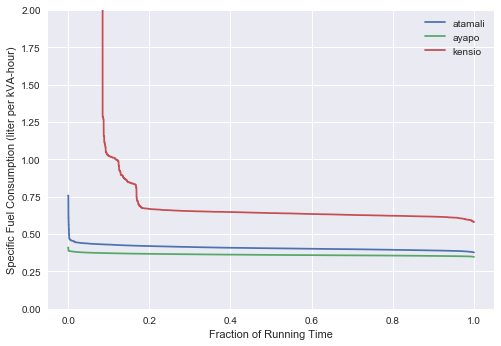

In [9]:
fig, ax = plt.subplots()
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    kVA = energy_data['kVA sliding window Demand'].dropna().values
    kVA = kVA[kVA != 0.0]
    # create fuel rate time series from kVA data
    fuel_rate = get_fuel_rate(rfd['genset_rating_kVA'], kVA)
    fuel_per_kVA_hour = fuel_rate / kVA
    fuel_per_kVA_hour.sort()
    fuel_per_kVA_hour = fuel_per_kVA_hour[::-1]
    index = np.linspace(0, 1, len(fuel_per_kVA_hour))
    plt.plot(index, fuel_per_kVA_hour,
             label=vname)

print('Specific Fuel Consumption Duration Curves')
plt.legend()
plt.xlabel('Fraction of Running Time')
plt.ylabel('Specific Fuel Consumption (liter per kVA-hour)')
plt.ylim((0,2))
plt.savefig('../plots/specific_fuel_consumption_duration.png')
plt.show()


In [10]:
data = []
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    kVA = energy_data['kVA sliding window Demand'].dropna().values
    kVA = kVA[kVA != 0.0]
    fuel_rate = get_fuel_rate(rfd['genset_rating_kVA'], kVA)
    fuel_per_kVA_hour = fuel_rate / kVA
    data.append({'village' : vname,
                 'max fuel rate' : fuel_rate.max(),
                 'min fuel rate' : fuel_rate.min(),
                 'max fuel per kVA' : fuel_per_kVA_hour.max(),
                 'min fuel per kVA' : fuel_per_kVA_hour.min(),
                 'mean fuel per kVA' : fuel_per_kVA_hour.mean(),
                 'max kVA' : kVA.max(),
                 'min kVA' : kVA.min(),
                 'capacity' : rfd['genset_rating_kVA']})
pd.DataFrame(data)

,capacity,max fuel per kVA,max fuel rate,max kVA,mean fuel per kVA,min fuel per kVA,min fuel rate,min kVA,village
0,25.0,0.757176,1.463800,3.884,0.407578,0.376880,0.645114,0.852,atamali
1,40.0,0.410306,5.905758,17.041,0.361626,0.346562,3.815028,9.298,ayapo
2,35.0,9.433381,1.886330,3.253,0.949917,0.579874,1.037672,0.110,kensio


In [11]:
data = []
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    kVA = energy_data['kVA sliding window Demand'].dropna().values
    kVA = kVA[kVA != 0.0]
    mean_kVA = kVA.mean()
    data.append({'village' : vname,
                 'genset rating kVA' : rfd['genset_rating_kVA'],
                 'expected fuel rate at 100% (lph)' : get_fuel_rate(rfd['genset_rating_kVA'], rfd['genset_rating_kVA'] * 1.0),
                 'mean load (kVA)' : mean_kVA,
                'expected fuel rate at mean load (lph)' : get_fuel_rate(rfd['genset_rating_kVA'], mean_kVA),
              
                })

data = pd.DataFrame(data)
data = data.set_index(['village'])
data = data[['genset rating kVA', 
             'expected fuel rate at 100% (lph)', 
             'mean load (kVA)',
             'expected fuel rate at mean load (lph)']]

print(tabulate.tabulate(data, tablefmt='pipe', headers=data.columns))
data

|         |   genset rating kVA |   expected fuel rate at 100% (lph) |   mean load (kVA) |   expected fuel rate at mean load (lph) |
|:--------|--------------------:|-----------------------------------:|------------------:|----------------------------------------:|
| atamali |                  25 |                            7.16545 |           3.05753 |                                 1.24064 |
| ayapo   |                  40 |                           12.105   |          14.3235  |                                 5.17199 |
| kensio  |                  35 |                           10.4585  |           2.45143 |                                 1.66989 |


,genset rating kVA,expected fuel rate at 100% (lph),mean load (kVA),expected fuel rate at mean load (lph)
village,,,,
atamali,25.0,7.165446,3.057530,1.240641
ayapo,40.0,12.105042,14.323494,5.171989
kensio,35.0,10.458510,2.451428,1.669893


In [15]:
data = []
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    kVA = energy_data['kVA sliding window Demand'].dropna().values
    kVA = kVA[kVA != 0.0]
    mean_kVA = kVA.mean()
    rating = rfd['genset_rating_kVA']
    load = rating * 1.0
    specific_fuel_consumption_100 = get_fuel_rate(rating, load) / load 
    load = mean_kVA
    specific_fuel_consumption_mean = get_fuel_rate(rating, load) / load  
    data.append({'Village' : vname.title(),
                 'Genset rating (kVA)' : rfd['genset_rating_kVA'],
                 #'expected fuel rate at 100% (lph)' : get_fuel_rate(rfd['genset_rating_kVA'], rfd['genset_rating_kVA'] * 1.0),
                 #'mean load (kVA)' : mean_kVA,
                #'expected fuel rate at mean load (lph)' : get_fuel_rate(rfd['genset_rating_kVA'], mean_kVA),
                'Expected specific fuel consumption at 100% load (lpkVA)': specific_fuel_consumption_100,
                'Expected specific fuel consumption at mean load (lpkVA)': specific_fuel_consumption_mean,
                })

data = pd.DataFrame(data)
#data = data.set_index(['village'])
#data = data[['genset rating kVA', 
#             'expected fuel rate at 100% (lph)', 
#             'mean load (kVA)',
#             'expected fuel rate at mean load (lph)']]
data = data[['Village', 
             'Genset rating (kVA)', 
             'Expected specific fuel consumption at 100% load (lpkVA)',
             'Expected specific fuel consumption at mean load (lpkVA)']]

table_string = tabulate.tabulate(data, tablefmt='pipe', floatfmt='.3g', headers=data.columns, showindex=False)

print(table_string)

#with open('../tables/modeled_SFC.md', 'w') as f:
#    f.write(table_string)
    
data

| Village   |   Genset rating (kVA) |   Expected specific fuel consumption at 100% load (lpkVA) |   Expected specific fuel consumption at mean load (lpkVA) |
|:----------|----------------------:|----------------------------------------------------------:|----------------------------------------------------------:|
| Atamali   |                    25 |                                                     0.287 |                                                     0.406 |
| Ayapo     |                    40 |                                                     0.303 |                                                     0.361 |
| Kensio    |                    35 |                                                     0.299 |                                                     0.681 |


,Village,Genset rating (kVA),Expected specific fuel consumption at 100% load (lpkVA),Expected specific fuel consumption at mean load (lpkVA)
0,Atamali,25.0,0.286618,0.405766
1,Ayapo,40.0,0.302626,0.361084
2,Kensio,35.0,0.298815,0.681192


In [13]:
# observed specific fuel consumption

data_zf = {}
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    messages = wpa.load_message_file(vname + '-messages.csv')
    # zero filled data
    data_zf[vname] = wpa.insert_zeros_energy(energy_data, messages)

In [14]:
data = []
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    daily_energy = data_zf[vname]['kWh export'].diff().resample('D').sum()
    operating_daily_energy = daily_energy[daily_energy > 0]
    try:
        observed_fuel = rfd['observed_fuel_liter_per_day']
        observed_SFC = observed_fuel / operating_daily_energy.mean()
    except:
        observed_fuel = None
        observed_SFC = None
    data.append({'Village' : vname.title(),
                 'Observed daily fuel (liters per day)' : observed_fuel,
                 'Mean Energy on Operating Days (kWh)' : operating_daily_energy.mean(),
                 'Observed SFC (lpkWh)' : observed_SFC})
    
table = pd.DataFrame(data)
table = table[['Village', 'Observed daily fuel (liters per day)',
               'Mean Energy on Operating Days (kWh)', 'Observed SFC (lpkWh)']]

table_string = tabulate.tabulate(table, tablefmt='pipe', headers=table.columns, floatfmt='.3g', showindex=False)

with open('../tables/observed_SFC.md', 'w') as f:
    f.write(table_string)
    
print(table_string)
table


| Village   |   Observed daily fuel (liters per day) |   Mean Energy on Operating Days (kWh) |   Observed SFC (lpkWh) |
|:----------|---------------------------------------:|--------------------------------------:|-----------------------:|
| Atamali   |                                     30 |                                 15.2  |                  1.97  |
| Ayapo     |                                     60 |                                 90    |                  0.667 |
| Kensio    |                                     15 |                                  9.12 |                  1.64  |


,Village,Observed daily fuel (liters per day),Mean Energy on Operating Days (kWh),Observed SFC (lpkWh)
0,Atamali,30,15.212963,1.972002
1,Ayapo,60,90.009091,0.666599
2,Kensio,15,9.122807,1.644231
